<a href="https://colab.research.google.com/github/mohitraosatya/qbraid-annealing-prototype/blob/main/qbraid_annealing_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install dimod dwave-neal networkx matplotlib

  Using cached dimod-0.12.20-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 57.1 MB/s eta 0:00:00


In [26]:
import networkx as nx
import dimod
from neal import SimulatedAnnealingSampler
import matplotlib.pyplot as plt

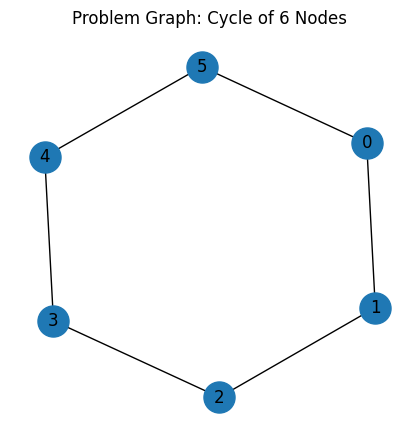

In [27]:
# Example: 6‑node cycle graph
G = nx.cycle_graph(6)

# Layout for plotting
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(4,4))
nx.draw(G, pos=pos, with_labels=True, node_size=500)
plt.title("Problem Graph: Cycle of 6 Nodes")
plt.show()


In [32]:
# We want to **maximize** sum_{(u,v)} δ(x_u != x_v)
# For binary x in {0,1}, one can show minimizing
#   E(x) = -∑_u deg(u)*x_u  + 2∑_{(u,v)} x_u x_v
# will find the max‑cut.

# Linear biases hᵢ = -deg(i)
h = {i: -G.degree[i] for i in G.nodes()}

# Quadratic couplings J_{u,v} = +2 for each edge
J = {(u, v): 2 for u, v in G.edges()}

# Build the BQM
bqm = dimod.BinaryQuadraticModel(h, J, offset=0.0, vartype=dimod.BINARY)


In [33]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=200)

# Best (lowest energy) sample
best = sampleset.first
print("Best energy:", best.energy)
print("Best sample:", best.sample)


Best energy: -6.0
Best sample: {0: np.int8(1), 1: np.int8(0), 2: np.int8(1), 3: np.int8(0), 4: np.int8(1), 5: np.int8(0)}


In [34]:
# Assignments: 0 or 1
group0 = [n for n, val in best.sample.items() if val == 0]
group1 = [n for n, val in best.sample.items() if val == 1]

# Count edges crossing groups
cut_edges = [(u, v) for u, v in G.edges() if best.sample[u] != best.sample[v]]
cut_size = len(cut_edges)

print(f"Group 0: {group0}")
print(f"Group 1: {group1}")
print(f"Cut size: {cut_size} of {G.number_of_edges()} edges")


Group 0: [1, 3, 5]
Group 1: [0, 2, 4]
Cut size: 6 of 6 edges


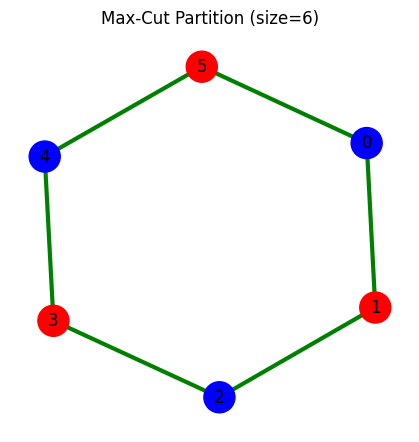

In [35]:
node_colors = ['red' if best.sample[n] == 0 else 'blue' for n in G.nodes()]

plt.figure(figsize=(4,4))
nx.draw(G, pos=pos, with_labels=True,
        node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos=pos, edgelist=cut_edges,
                       width=3.0, edge_color='green')
plt.title(f"Max‑Cut Partition (size={cut_size})")
plt.show()
